# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.

Good luck & have fun! :)

In [1]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

**✨ Внимание ✨**

В этом домашнем задании предлагается использовать библиотеку `pytorch_lightning`. Доступ к ее [документации](https://lightning.ai/docs/pytorch/stable/) заблокирован с территории РФ. Вы можете:

1. Получить к ней доступ с помощью VPN.

2. Собрать документацию самостоятельно. Для этого склонируйте [github-репозиторий](https://github.com/Lightning-AI/lightning/tree/master), запустите в нем терминал (на windows – git bash) и выполните команды:

```shell
git submodule update --init --recursive
make docs
```
После этого откройте появившийся файл `docs/build/html/index.html`. Для работы команд в вашем окружении должен быть `pip`. Полная инструкция [по ссылке](https://github.com/Lightning-AI/lightning/tree/master/docs).

3. Гуглить `<error message> pytorch lightning` или `<how to do this> pytorch lightning`. Stack overflow на территории РФ все еще доступен 😉

4. Не пользоваться `pytorch_lightning` и написать цикл обучения модели самостоятельно. Например, по аналогии с функцией `fit` из [семинара 4](https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/04.%20Optim%20%26%20Lightning/04_Optim%26Lightning_solution.ipynb).

In [2]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms.v2 as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Subset
from torch.nn.modules.loss import CrossEntropyLoss
from torchvision.models import resnet18, ResNet18_Weights, vit_b_16

from tqdm import tqdm

In [5]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [6]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2023-11-15 18:45:40--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2023-11-15 18:45:40--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdb67246710a9fc0e7a889bcd98.dl.dropboxusercontent.com/cd/0/get/CHkd_01q81QEPoJTj-ontIsuVUD-bTEYrkwvEP66nPCu8WTgtXwO7LVvuCaGrzxGvVcIc88bk_Y4fTKOvBxy1VrS1q3BToacFFNLiGiVWoCXEavnsVeaCMfweM7xDkVKVx1LrjXokyzY5oB1GjpED6pQ/file?dl=1# [following]
--2023-11-15 18:45:41--  https://ucdb67246710a9fc0e7a889bcd98.dl.dropboxusercontent.com/cd/0/get/CHkd_01q81QEPoJTj-ontIsuVUD-bTEYrkwvEP66nPCu8WTgtXwO7LVvuCaGrzxGvVcIc88bk_Y4fTKOvBxy1VrS1q3BToacFFNLiGi

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.ColorJitter(hue=0.05, saturation=0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
train_subset = Subset(train_dataset, [True] * 5 + [False] * 99995)
val_subset = Subset(val_dataset, [True] * 5 + [False] * 9995)

sub_train_dataloader = DataLoader(train_subset, batch_size=256, shuffle=True, num_workers=2)
sub_val_dataloader = DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=2)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

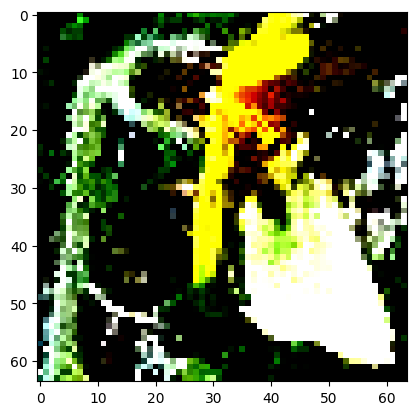

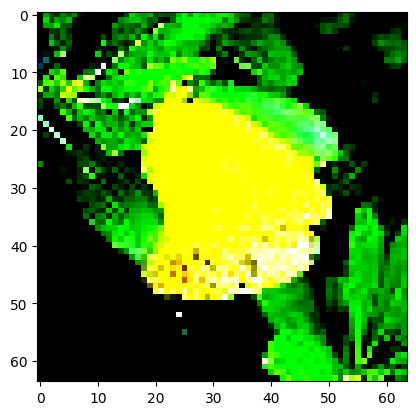

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1.

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, lr: float = 1e-3, weights: torch.Tensor = None, pretrained: bool = False) -> None:
        super().__init__()
        self.pretrained = pretrained
        self.model = model
        self.optimizer = torch.optim.Adam(weights, lr=lr)
        self.scheduler = ExponentialLR(self.optimizer, gamma=0.9)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return [self.optimizer], [self.scheduler]

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(),
                       task='multiclass', num_classes=200)
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [ ]:
# for first training
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device = "cuda" if torch.cuda.is_available() else "cpu"

model = resnet18(weights=None, num_classes=200).to(device)
module = YourModule(model, lr=3e-4, weights=model.parameters())

trainer = pl.Trainer(logger=wandb_logger, max_epochs=15)
trainer.fit(module, train_dataloader, val_dataloader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True

INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores

INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs

INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

INFO:pytorch_lightning.callbacks.model_summary:

  | Name  | Type             | Params

-------------------------------------------

0 | model | ResNet           | 11.3 M

1 | loss  | CrossEntropyLoss | 0     

-------------------------------------------

11.3 M    Trainable params

0         Non-trainable params

11.3 M    Total params

45.116    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


accuracy,▁▃▄▅▆▆▇▇▇██████
epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
train_loss,█▇▇▆▆▆▆▅▄▅▄▅▄▅▄▄▃▃▃▃▃▂▃▂▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁
accuracy,0.3917
epoch,14
train_loss,1.45788
trainer/global_step,11729
val_loss,2.69571


In [ ]:
# # for continue training from checkpoint
# wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model = resnet18(weights=None, num_classes=200).to(device)
# net = torch.load('/content/resnet18-aug-10epochs.pth')
# model.load_state_dict(net)
# module = YourModule(model, lr=3e-4, weights=model.parameters())

# trainer = pl.Trainer(logger=wandb_logger, max_epochs=10)
# trainer.fit(module, train_dataloader, val_dataloader, ckpt_path='/content/lightning_logs/6srqh19x/checkpoints/epoch=4-step=1955.ckpt')
# wandb.finish()

In [ ]:
PATH = 'resnet18-aug-adam-15epochs-reduce_batch.pth'

torch.save(model.state_dict(), PATH)

# download checkpoint file
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Валидация результатов задания

In [7]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy_ = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            acc_batch = accuracy(model(images), labels,
                       task='multiclass', num_classes=200)
        accuracy_ += acc_batch
    accuracy_ = accuracy_ / len(test_dataloader)
    return accuracy_

In [ ]:
net = torch.load(PATH)
model = resnet18(weights=None, num_classes=200)
model.load_state_dict(net)

accuracy_ = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy_.detach().cpu().numpy() / 0.44, 0, 10):.2f} баллов")



  0%|          | 0/79 [00:00<?, ?it/s]

  1%|▏         | 1/79 [00:00<00:19,  3.98it/s]

  4%|▍         | 3/79 [00:00<00:08,  9.14it/s]

  6%|▋         | 5/79 [00:00<00:06, 11.63it/s]

  9%|▉         | 7/79 [00:00<00:05, 13.61it/s]

 11%|█▏        | 9/79 [00:00<00:04, 14.28it/s]

 15%|█▌        | 12/79 [00:00<00:04, 14.86it/s]

 18%|█▊        | 14/79 [00:01<00:04, 15.18it/s]

 20%|██        | 16/79 [00:01<00:04, 15.02it/s]

 23%|██▎       | 18/79 [00:01<00:04, 15.21it/s]

 25%|██▌       | 20/79 [00:01<00:03, 15.16it/s]

 28%|██▊       | 22/79 [00:01<00:03, 15.62it/s]

 30%|███       | 24/79 [00:01<00:03, 15.58it/s]

 33%|███▎      | 26/79 [00:01<00:03, 16.13it/s]

 35%|███▌      | 28/79 [00:01<00:03, 15.75it/s]

 38%|███▊      | 30/79 [00:02<00:03, 15.38it/s]

 41%|████      | 32/79 [00:02<00:03, 15.11it/s]

 43%|████▎     | 34/79 [00:02<00:02, 15.10it/s]

 46%|████▌     | 36/79 [00:02<00:02, 15.29it/s]

 48%|████▊     | 38/79 [00:02<00:02, 15.43it/s]

 51%|█████     | 40/79 [00:02<00

Оценка за это задание составит 8.99 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

### Тренировочный класс lightning

In [8]:
class YourModule(pl.LightningModule):
    def __init__(self, model, lr: float = 1e-3) -> None:
        super().__init__()

        self.model = model

        self.optimizer = torch.optim.Adam(self.model.heads.parameters(), weight_decay=5e-4, lr=lr)
        self.scheduler = ExponentialLR(self.optimizer, gamma=0.9)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return [self.optimizer], [self.scheduler]

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(),
                       task='multiclass', num_classes=200)
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [9]:
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),

        transforms.ColorJitter(hue=0.05, saturation=0.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.RandomRotation(15),

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
# val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataset = ImageFolder('/kaggle/working/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/kaggle/working/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [10]:
# for first training
wandb_logger = WandbLogger(log_model='all')

device = "cuda" if torch.cuda.is_available() else "cpu"
model = vit_b_16(weights='DEFAULT').to(device)
for param in model.parameters():
        param.requires_grad = False
trainable_model = nn.Sequential(
    nn.Linear(768, 400),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(400, 200)
)
model.heads = trainable_model.to(device)
module = YourModule(model, lr=3e-4)

trainer = pl.Trainer(logger=wandb_logger, max_epochs=8)
trainer.fit(module, train_dataloader, val_dataloader)
wandb.finish()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 301MB/s] 
wandb: Currently logged in as: grigvasilisa (grigorevaaa). Use `wandb login --relogin` to force relogin


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

accuracy,▁▄▆▇▇███
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▄▃▂▂▁▁▁
accuracy,0.8395
epoch,7
train_loss,0.85133
trainer/global_step,3127
val_loss,0.60292


In [ ]:
PATH = 'task2-tl-vit16-toimageaug.pth'

torch.save(model.state_dict(), PATH)

# download checkpoint file
files.download(PATH)

### Валидация результатов задания

In [13]:
net = torch.load(PATH)
model = vit_b_16(weights=None).to(device)
model.heads = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 200)
)
model.load_state_dict(net)

accuracy_ = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy_.detach().cpu().numpy() - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 40/40 [00:59<00:00,  1.49s/it]

Оценка за это задание составит 9.97 баллов


# Отчёт об экспериментах

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

В обоих заданиях было принято решение не изобретать велосипед, а воспользоваться существующими моделями.

1 задание.

Обучала resnet18 c нуля, удалось достигнут хорошего скоро, помогли оптимайзер и шедулер, долго подбирала лр. Экспериментировала с оптимайзером (приложу графики)

Можно посмотреть только отчет, там собраны все графики


* https://wandb.ai/grigorevaaa/lightning_logs/reports/iad_hw2-task1--Vmlldzo1OTc2MDMx?accessToken=jey3myyslubyo1dqee7x4rmg0orbqrn42jhebi9v66rw41tj12y11uyxqiyz4l6d - отчет
*   https://api.wandb.ai/links/grigorevaaa/sanf1rtk - val loss
*   https://wandb.ai/grigorevaaa/lightning_logs/reports/train_loss-23-11-12-23-59-07---Vmlldzo1OTQ3ODc2 - loss
*   https://wandb.ai/grigorevaaa/lightning_logs/reports/accuracy-23-11-12-23-59-25---Vmlldzo1OTQ3ODc5?accessToken=23l7qgbvj80sio74yr1y8hw2t68q4rct3c1jpgb1k86pc97czmav17yjtg0nlvx1 - accuracy




Задание 2

* https://wandb.ai/grigorevaaa/grigoreva_iad_hw2_task2/reports/Untitled-Report--Vmlldzo1OTgyMTM4?accessToken=my6d01z8z6wjdtp2x15kfrc3lu10hi2byn1ya84ozx0xq9lk7gli234uxs0i4qb4 - отчет